# Init

**TODO**

1. Refactor and clean code
1. Single method for construction of network
1. Record experiment with wandb
1. bayesian optimization of hyperparameters
1. better richer data

In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import numpy as np
import seaborn as sns
import pylab as plt

%matplotlib inline

In [3]:
# import wandb
# wandb.init(project="circuit-seq")

# Data Generation

We define a basic function, the `sigmoid` for simulating a chemical reaction network.

## Utilities

### Make Deterministic

In [34]:
import random
import torch
import numpy

SEED=0

def make_deterministic(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### CircuitGenerator

In [58]:
import networkx as nx
import numpy as np
import torch
from itertools import permutations
from functools import partial
from typing import Tuple, Hashable, List
import itertools

def has_cycle(g: nx.DiGraph) -> bool:
    try:
        nx.find_cycle(g)
        return True
    except nx.NetworkXNoCycle:
        return False


def to_one_hot(arr: torch.tensor, mx: int):
    oh = torch.zeros((arr.shape[0], mx))
    for i, a in enumerate(arr):
        oh[i, a] = 1.0
    return oh


def sigmoid(x, a, kd, n, offset, inv):
    return a - (a) / (1. + np.exp((-x + kd) * n * inv)) + offset

# class Augment:
#     @staticmethod
#     def add_all_edges(g):
#         nodes = list(g.nodes())
#         for n1, n2 in itertools.product(nodes, repeat=2):
#             if n2 not in g[n1] or g[n1][n2] is None or len(g[n1][n2]) == 0:
#                 g.add_edge(n1, n2, features=torch.tensor([0.]), target=torch.tensor([0.]))
#         return g

class CircuitGenerator(object):

    functions = {
        'sigmoid': sigmoid
    }

    def __init__(self, n_parts: int):
        self.n_parts = n_parts
        self.func_name = 'sigmoid'
        assert self.func_name in self.functions
        params, labels = self.random_params(self.n_parts)
        self.params = params
        self.param_labels = params

    @property
    def func(self):
        return self.functions[self.func_name]

    def random_params(self, num):
        A = np.random.uniform(1, 20, size=(num))
        K = np.random.uniform(1, 20, size=(num))
        n = np.random.uniform(1, 2, size=(num))
        o = np.random.uniform(0, A.max() / 10., size=(num))

        A = np.expand_dims(A, 1)
        K = np.expand_dims(K, 1)
        n = np.expand_dims(n, 1)
        o = np.expand_dims(o, 1)

        # choose repressor (1) or activator (-1)
        i = np.random.choice([1], (num, 1))

        # [n_parts, n_params]
        params = np.hstack([A, K, n, o, i])
        labels = np.array(['A', 'K', 'n', 'o', 'i'])
        return params, labels

    def steady_state(self, g, acc='sum', node_to_part=lambda x: int(x)):
        acc_dict = {
            'sum': lambda x: np.sum(np.concatenate(x))
        }

        # in topological order, we evaluate the sigmoid function at each node
        for node in nx.topological_sort(g):

            idx = node_to_part(node)
            # gather all parents
            # accumulate outputs 'y' using the provided accumulation function
            parents = list(g.predecessors(node))
            if not parents:
                p = np.expand_dims(self.params[idx:idx + 1].T, 2)
                x = np.array([[0.]])
            else:
                a = []
                for p in parents:
                    _x = g.nodes[p]['y']
                    a.append(_x)
                if len(a) and len(a[0]):
                    x = acc_dict[acc](a)
                    x = x.reshape(_x.shape)
                else:
                    x = torch.tensor([], dtype=torch.float)
            y = self._partial_func(self.func_name, x, idx)
            g.nodes[node]['y'] = y

    def _partial_func(self, fname, x, node: Hashable):
        return self.functions[fname](x, *tuple(np.expand_dims(self.params[node:node + 1].T, 2)))

    def annotate_graph_with_features(self, g: nx.DiGraph, include_target: bool = True):
        # one-hot encode the graph nodes
        one_hot_encoded = to_one_hot(torch.arange(0, self.n_parts), self.n_parts)

        new_g = nx.DiGraph()
        for n, data in g.nodes(data=True):
            new_g.add_node(n, **data)
        for n1, n2, edata in g.edges(data=True):
            edata['features'] = np.array([0.])
            if include_target:
                edata['target'] = np.array([1.])
            new_g.add_edge(n1, n2, **edata)
        if include_target:
            self.steady_state(new_g, node_to_part=lambda x: x[-1])
        for n, ndata in new_g.nodes(data=True):
            # convert this to ONE HOT!
            ndata['features'] = one_hot_encoded[list(n)[-1]]
            if include_target:
                ndata['target'] = torch.tensor([ndata['y'].flatten()], dtype=torch.float)
        new_g.data = {
            'features': torch.tensor([0])
        }
        if include_target:
            new_g.data['target'] = torch.tensor([0])

        return new_g

    @staticmethod
    def graph_from_nodes(nodes: List[Tuple[Hashable, Hashable, Hashable]]) -> nx.DiGraph:
        g = nx.DiGraph()
        for n1, n2 in permutations(nodes, r=2):
            if n1[-1] in (n2[0], n2[1]):
                g.add_edge(tuple(n1), tuple(n2))
        return g

    def random_circuit(self, part_range: Tuple[int, int]):
        num_nodes = np.random.randint(*part_range)
        nodes = np.random.randint(0, self.n_parts, size=(num_nodes, 3))
        g = self.graph_from_nodes(nodes)
        return g

    def iter_random_circuit(self, limit: int, part_range: Tuple[int, int], cycles: bool = True, annotate: bool = False) -> nx.DiGraph:
        new_circuit = partial(self.random_circuit, part_range=part_range)
        for i in range(limit):
            c = new_circuit()
            if cycles is True:
                pass
            else:
                while has_cycle(c):
                    c = new_circuit()
            if annotate:
                c = self.annotate_graph_with_features(c)
            yield c


#### Create Circuits

TODO: Save data generation parameters (function, part range, number of parts, parameters, number of graphs)

TODO: Save graphs as `.h5` file

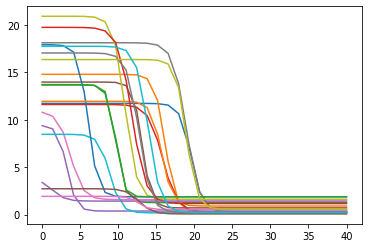

In [66]:
# test circuit generation process
make_deterministic(0)
generator = CircuitGenerator(20)

# visualize parts
x = np.repeat(np.expand_dims(np.linspace(0, 40, 30), 0), generator.n_parts, axis=0)
y = generator.func(x, *tuple(np.expand_dims(generator.params.T, 2)))
plt.plot(x.T, y.T)
plt.show()

# create graphs
graphs = list(generator.iter_random_circuit(100, (1, 20), annotate=True, cycles=False))

# verify graphs
for g in graphs:
    for n, ndata in g.nodes(data=True):
        assert 'features' in ndata

# augmentation
[Augment.add_all_edges(g) for g in tqdm(graphs)]

# create GraphBatch data
batch = GraphBatch.from_networkx_list(graphs, n_edge_feat=1, n_node_feat=20, n_glob_feat=1)
test_batch = GraphBatch.from_networkx_list(graphs, n_edge_feat=1, n_node_feat=1, n_glob_feat=1, feature_key='target')
datalist = batch.to_data_list()
testdatalist = test_batch.to_data_list()

#### Check Graphs

(3, 3, 18) {'y': array([[16.35681292]]), 'features': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0.]), 'target': tensor([[16.3568]])}
(18, 14, 9) {'y': array([[0.18587064]]), 'features': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]), 'target': tensor([[0.1859]])}
(3, 3, 18) (18, 14, 9)
(3, 3, 18) (3, 3, 18)
(18, 14, 9) (3, 3, 18)
(18, 14, 9) (18, 14, 9)


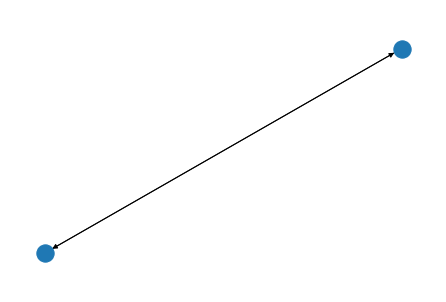

In [63]:
nx.draw(graphs[0])
for n, ndata in graphs[0].nodes(data=True):
    print(n, ndata)
    
for n1, n2 in graphs[0].edges():
    print(n1, n2)

In [64]:
# test iterable
for a, b in GraphDataLoader(list(zip(datalist, testdatalist)), batch_size=32):
    pass

## Data Generators

In [74]:
import random
import torch
import numpy

def split(arr, x):
    assert x > 0 and x <= 1
    i = int(len(arr)*x)
    j = len(arr) - i
    return arr[:i], arr[j:]

# test circuit generation process
make_deterministic(0)
generator = CircuitGenerator(20)

# new data
# ability to generalize larger circuits
def generate_data(train_size, train_part_range, devtest_size, devtest_part_range, train__train_dev_split=0.9, dev_test_split=0.5):
    # training distribution
    training_distribution = list(generator.iter_random_circuit(train_size, train_part_range, cycles=False, annotate=True))
    train_graphs, train_dev_graphs = split(training_distribution, train__train_dev_split)

    # dev/test distribution
    test_dev_distribution = list(generator.iter_random_circuit(devtest_size, devtest_part_range, cycles=False, annotate=True))
    dev_graphs, test_graphs = split(test_dev_distribution, dev_test_split)
    return {
        'train': train_graphs,
        'train/dev': train_dev_graphs,
        'dev': dev_graphs,
        'test': test_graphs
    }
# augmenting edges results in loss of learning ability
# [Augment.add_all_edges(g) for g in tqdm(graphs)]

def create_loader(graphs, batch_size, shuffle):
    train_batch = GraphBatch.from_networkx_list(train_graphs, n_edge_feat=1, n_node_feat=generator.n_parts, n_glob_feat=1)
    target_batch = GraphBatch.from_networkx_list(train_graphs, n_edge_feat=16, n_node_feat=1, n_glob_feat=1, feature_key='target')
    train_list = train_batch.to_data_list()
    target_list = target_batch.to_data_list()
    if batch_size is None:
        batch_size = len(train_list)
    return GraphDataLoader(list(zip(train_list, target_list)), batch_size=batch_size, shuffle=shuffle)
  
    
data = generate_data(10000, (2, 6), 2000, (2, 8))
train_loader = create_loader(data["train"], 512, shuffle=True)
eval_loader = create_loader(data["dev"], None, shuffle=False)

for a, b in eval_loader:
    pass
assert a

## Model

### MLP

In [75]:
from typing import List

from torch import nn

from pyrographnets.utils import pairwise

class MLPBlock(nn.Module):
    """A multilayer perceptron block."""

    def __init__(self, input_size: int, output_size: int = None):
        super().__init__()
        if output_size is None:
            output_size = input_size
        self.blocks = nn.Sequential(
            nn.Linear(input_size, output_size), nn.ReLU(), nn.LayerNorm(output_size)
        )

    def forward(self, x):
        return self.blocks(x)


class MLP(nn.Module):
    """A multilayer perceptron."""

    def __init__(self, *latent_sizes: List[int]):
        super().__init__()
        self.blocks = nn.Sequential(
            *[MLPBlock(n1, n2) for n1, n2 in pairwise(latent_sizes)]
        )

    def forward(self, x):
        return self.blocks(x)

### Network

In [76]:
from pyrographnets.models import GraphEncoder, GraphCore
from pyrographnets.blocks import EdgeBlock, NodeBlock, GlobalBlock, AggregatingEdgeBlock, AggregatingGlobalBlock, AggregatingNodeBlock, Aggregator
from pyrographnets.blocks import Flex
from pyrographnets.blocks import MLP

class Network(torch.nn.Module):
    
    def __init__(self):  
        super().__init__()
        
        latent_size = 254
        
        layers = (latent_size, latent_size, 16)
        
        self.encoder = GraphEncoder(
            EdgeBlock(MLP(1, layers[0])),
            NodeBlock(MLP(20, layers[1])),
            GlobalBlock(MLP(1, layers[2]))
        )
        
        self.core = GraphCore(
            AggregatingEdgeBlock(torch.nn.Sequential(
                Flex(MLP)(Flex.d(), latent_size, latent_size, layers[0]),
#                 torch.nn.Linear(layers[0], layers[0])
            )),
            AggregatingNodeBlock(torch.nn.Sequential(
                Flex(MLP)(Flex.d(), latent_size, latent_size, layers[1]),
#                 torch.nn.Linear(layers[1], layers[1])
            ), Aggregator('add')),
            AggregatingGlobalBlock(Flex(MLP)(Flex.d(), layers[2]), Aggregator('add'), Aggregator('add')),
            pass_global_to_edge=True,
            pass_global_to_node=True
        )
        
        self.decoder = GraphEncoder(
            EdgeBlock(Flex(MLP)(   Flex.d(),   latent_size, layers[0])),
            NodeBlock(Flex(MLP)(   Flex.d(),   latent_size, layers[1])),
            GlobalBlock(Flex(MLP)( Flex.d(),   layers[2]))
        )
                
        self.output_transform = GraphEncoder(
            EdgeBlock(Flex(torch.nn.Linear)(Flex.d(), 1)),
            NodeBlock(Flex(torch.nn.Linear)(Flex.d(), 1)),
            GlobalBlock(Flex(torch.nn.Linear)(Flex.d(), 1)),
        )
        
    def forward(self, data, steps):

        # encoded
        e, x, g = self.encoder(data)
        data = GraphBatch(x, e, g, data.edges, data.node_idx, data.edge_idx)
        
        # graph topography data
        edges = data.edges
        node_idx = data.node_idx
        edge_idx = data.edge_idx
        latent0 = data
        
        meta = (edges, node_idx, edge_idx)
        
        outputs = []
        for _ in range(steps):
            # core processing step
            e = torch.cat([latent0.e, e], dim=1)
            x = torch.cat([latent0.x, x], dim=1)
            g = torch.cat([latent0.g, g], dim=1)
            data = GraphBatch(x, e, g, *meta)
            e, x, g = self.core(data)
        
            # decode 
            data = GraphBatch(x, e, g, *meta)
            
            _e, _x, _g = self.decoder(data)
            decoded = GraphBatch(_x, _e, _g, *meta)
            
            # transform
            _e, _x, _g = self.output_transform(decoded)
            outputs.append(GraphBatch(_x, _e, _g, edges, node_idx, edge_idx))
            
        # revise connectivity
        
        return outputs
        
net = Network()

# for samples in loader:
# #     print(samples[0].x.shape)
#     out = net(samples[0], 10)

### Misc Blocks

In [77]:
import torch


class Select(torch.nn.Module):
    """Differentiable select block"""
    def __init__(self, input_size: int, output_size: int):
        super().__init__()
        self.blocks = torch.nn.Sequential(
            torch.nn.Linear(input_size, output_size),
            torch.nn.Sigmoid()
        )

    def forward(self, data: torch.Tensor, latent: torch.Tensor) -> torch.Tensor:
        out = self.blocks(latent)
        i = torch.where(torch.round(out) == 1)[0]
        return data[i]

class SelectIndex(torch.nn.Module):
    
    def __init__(self, input_size: int, output_size: int):
        super().__init__()
        self.blocks = torch.nn.Sequential(
            torch.nn.Linear(input_size, output_size),
            torch.nn.Sigmoid()
        )
        
    def forward(self, data: torch.Tensor) -> torch.Tensor:
        """Note the output itself is NOT differentiable"""
        out = self.blocks(data)
        return self.blocks(data)

class NewNetwork(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.net1 = Network()
        self.select_index = Flex(SelectIndex)(Flex.d(), 1)
        self.net2 = Network()
        
    def forward(self, data, steps1, steps2 = None):
        if steps2 is None:
            steps2 = steps1
            
        # initial processing
        outputs = self.net1(data, steps1)
        
        # revise the edge connectivity
        i = self.select_index(outputs[-1].e)
        selected_data = GraphBatch(
            data.x,
            data.e * i,
            data.g,
            (data.edges * i.T).long(),
            data.node_idx,
            data.edge_idx
        )
        
        # repeat the processing
        return self.net2(selected_data, steps2)
    
model = NewNetwork()

for samples in loader:
    pass
model(samples[0], 10)

[<GraphBatch size(n,e,g)=torch.Size([438, 321, 113]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([438, 321, 113]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([438, 321, 113]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([438, 321, 113]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([438, 321, 113]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([438, 321, 113]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([438, 321, 113]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([438, 321, 113]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([438, 321, 113]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([438, 321, 113]) features(n,e,g)=torch.Size([1, 1, 1])>]

## Visualization Utilities

In [78]:
import seaborn as sns

def plot_kinetics(model, data, steps):
    
    with torch.no_grad():
        out = model(data, steps)
        x_arr = []
        for i, data in enumerate(out):
            t = torch.tensor([[i]] * data.x.shape[0], dtype=torch.float)
            index = torch.unsqueeze(torch.arange(data.x.shape[0], dtype=torch.float), 1)
            index = index.to(data.x.device)
            t = t.to(data.x.device)
            x = torch.cat([t, data.x, index], dim=1)
            x_arr.append(x)

        x = torch.cat(x_arr)
        df = pd.DataFrame({
            't': x[:, 0].detach().cpu(),
            'x': x[:, 1].detach().cpu(),
            'node': x[:, 2].detach().cpu()
        })
        df = df[df['node'] < 20]
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca()
        ax.set_ylim(-5, 20)
        sns.lineplot(x='t', y='x', hue='node', data=df, ax=ax)
        
    return ax, fig

## Train

torch.Size([20, 1, 1])


/home/justin/anaconda3/envs/torch/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/home/justin/anaconda3/envs/torch/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/home/justin/anaconda3/envs/torch/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/home/justin/anaconda3/envs/torch/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/home/justin/anaconda3/envs/torch/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that ar

KeyboardInterrupt: 

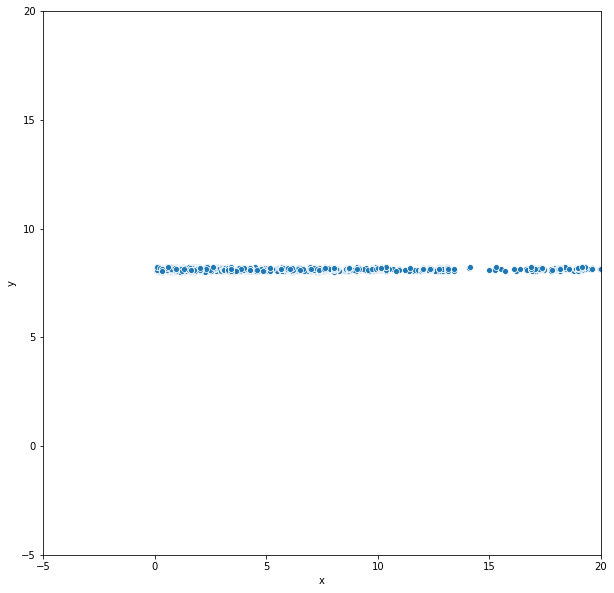

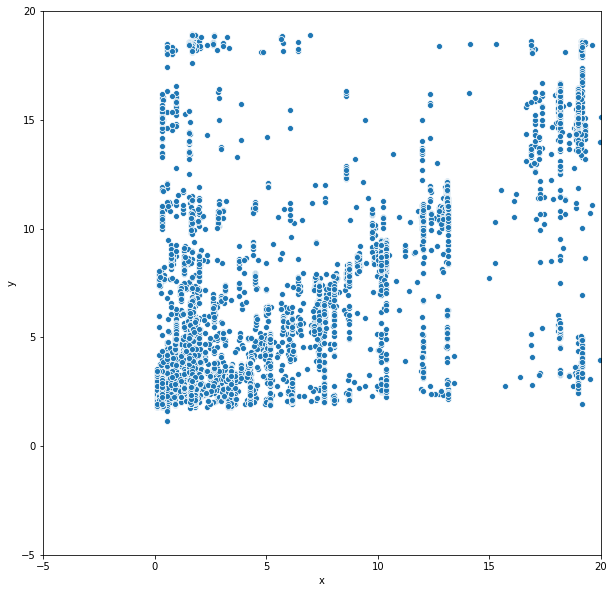

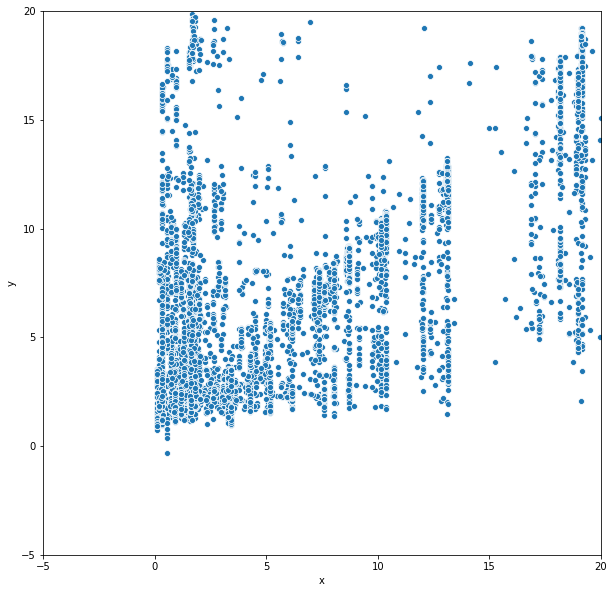

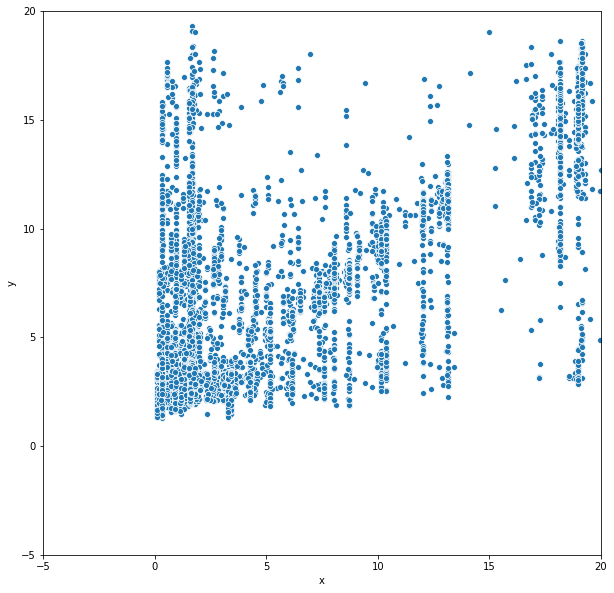

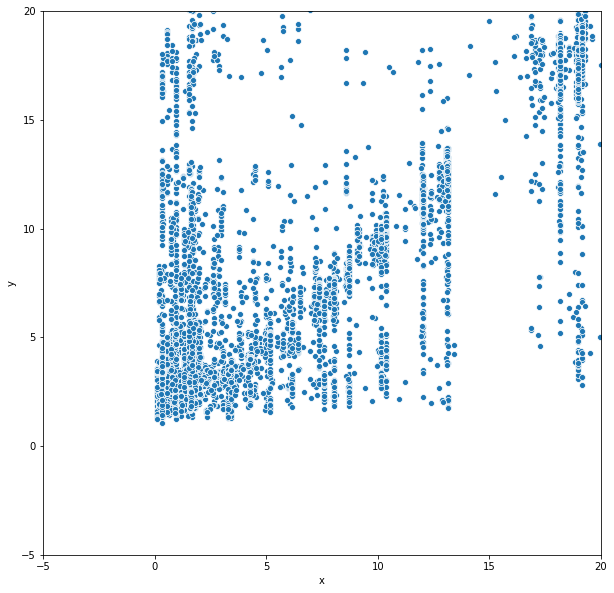

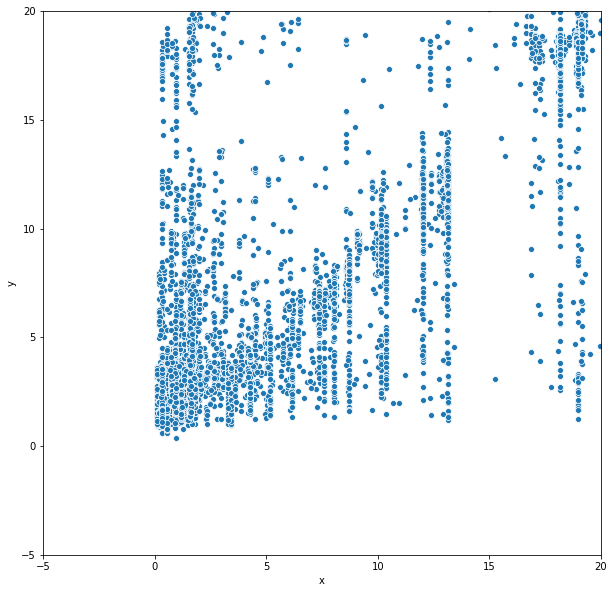

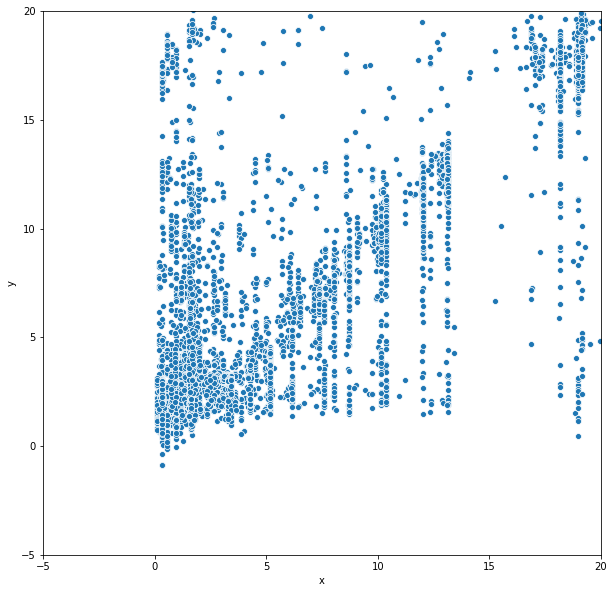

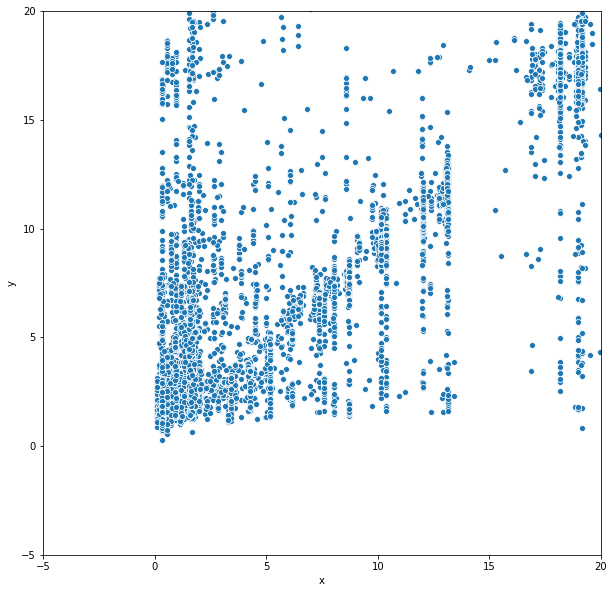

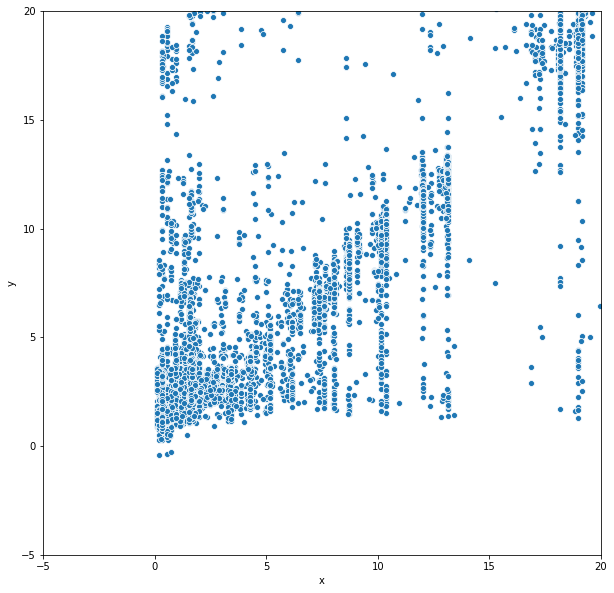

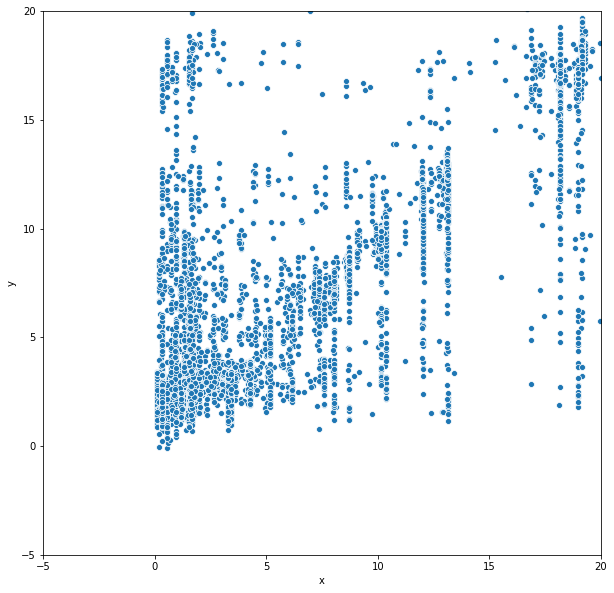

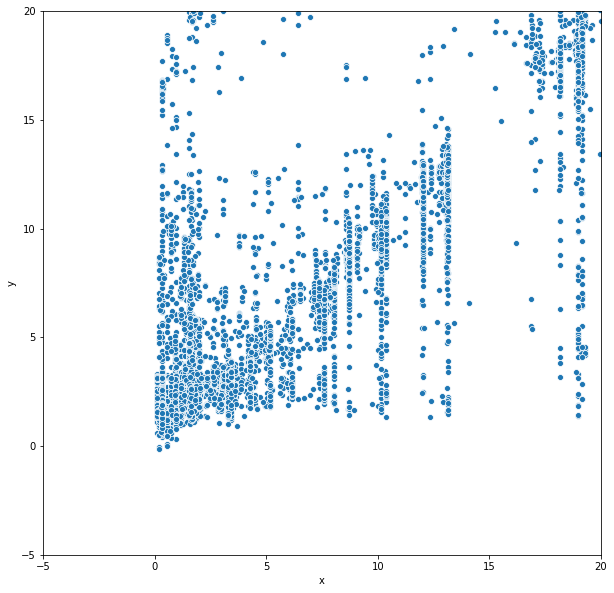

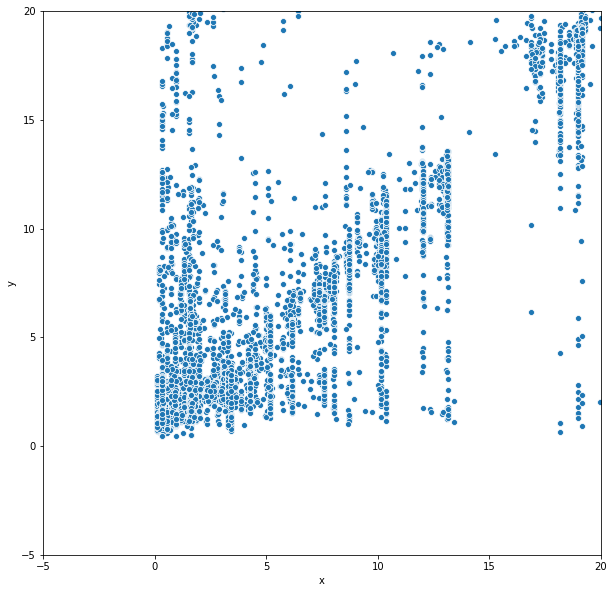

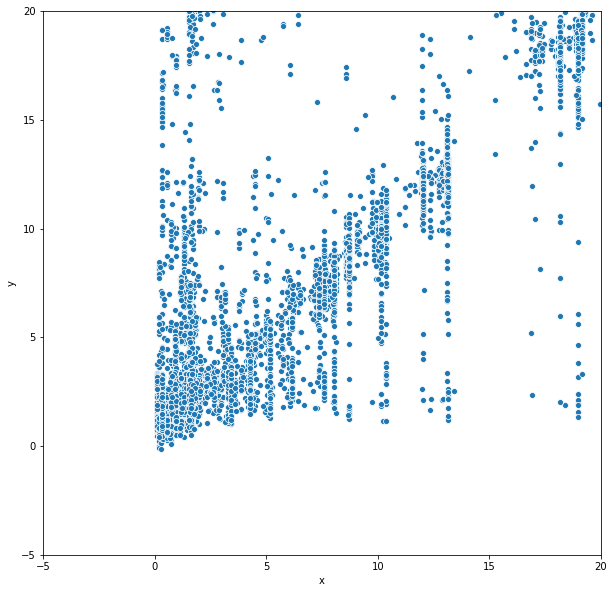

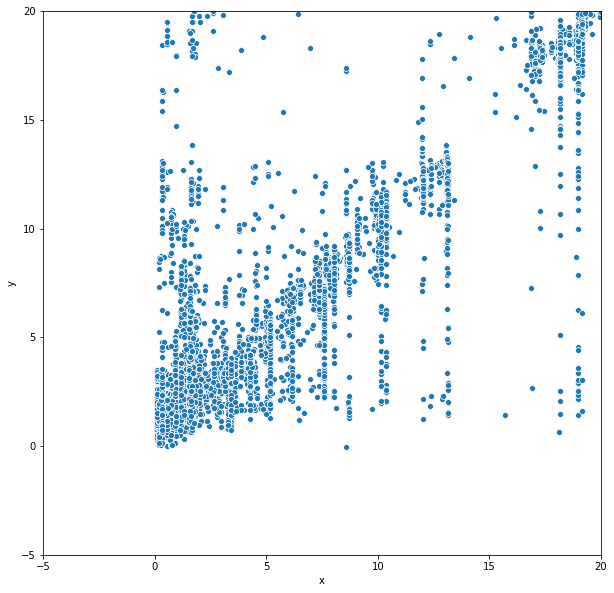

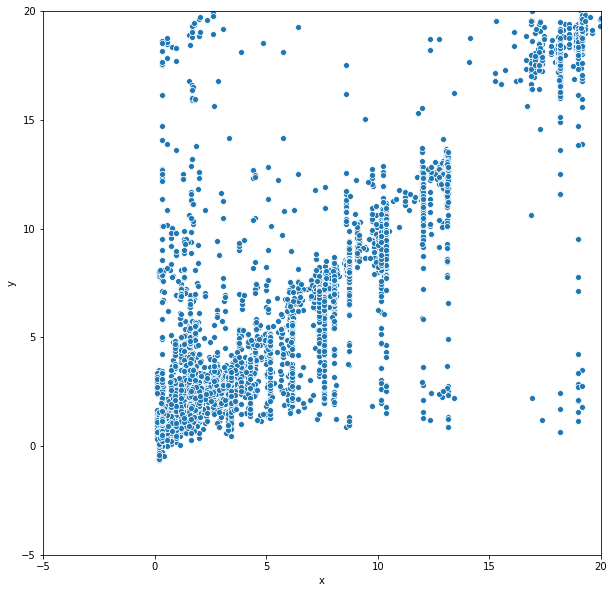

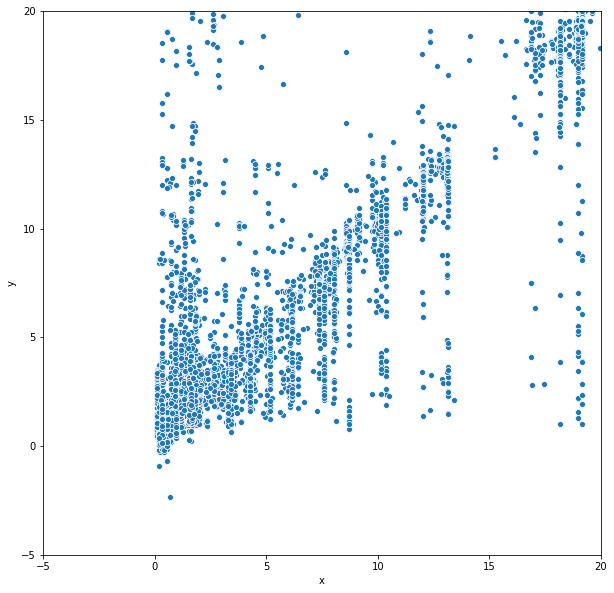

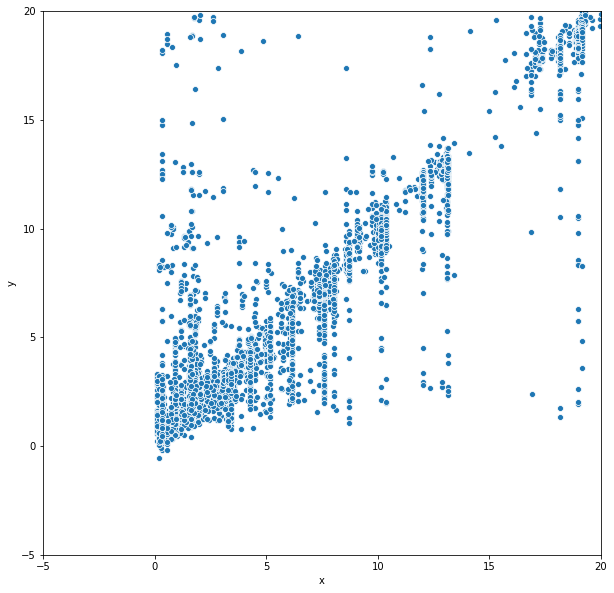

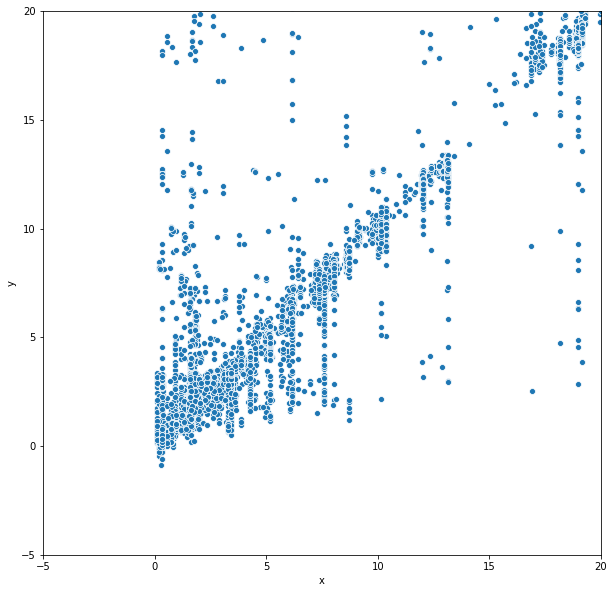

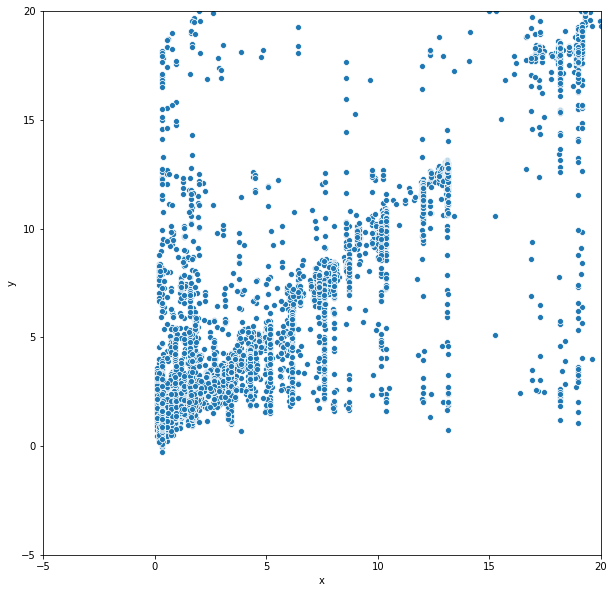

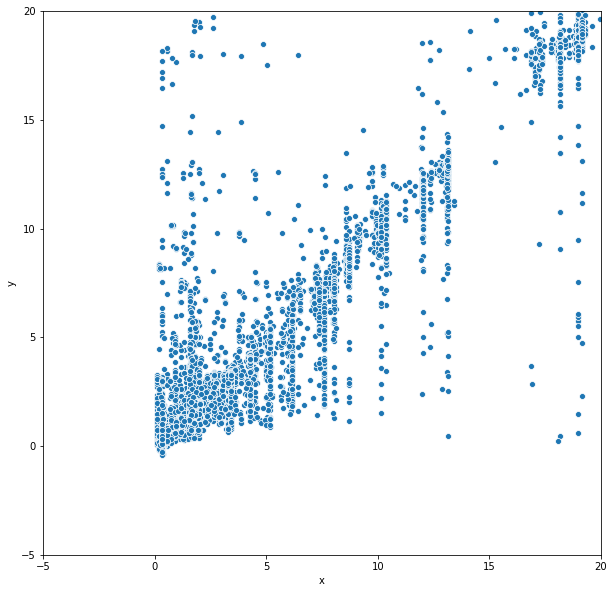

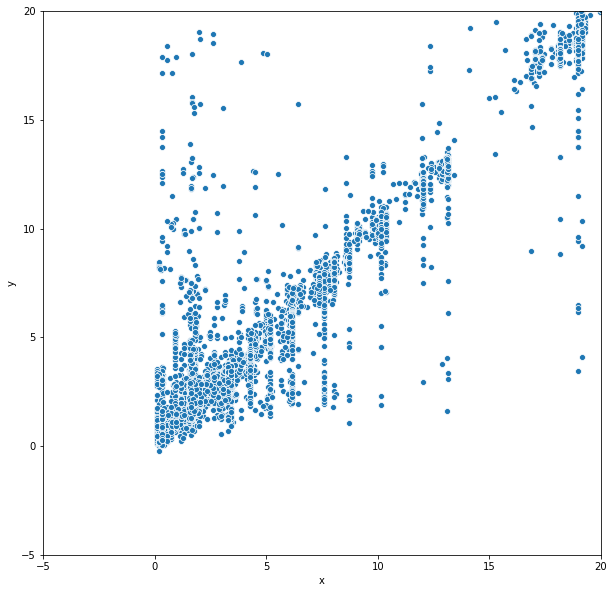

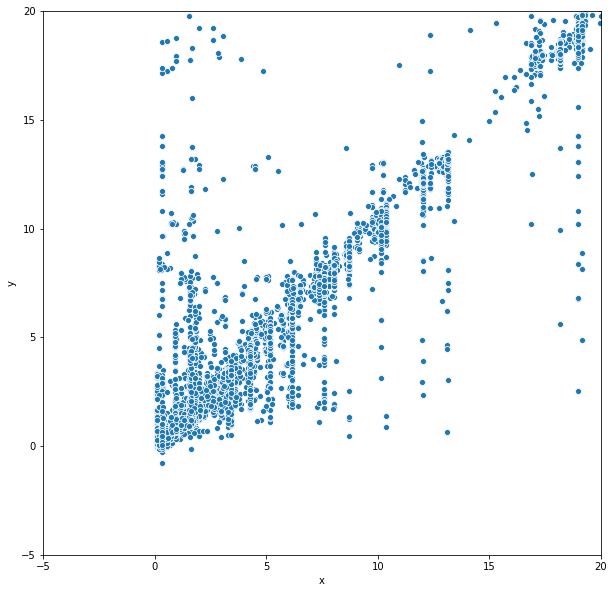

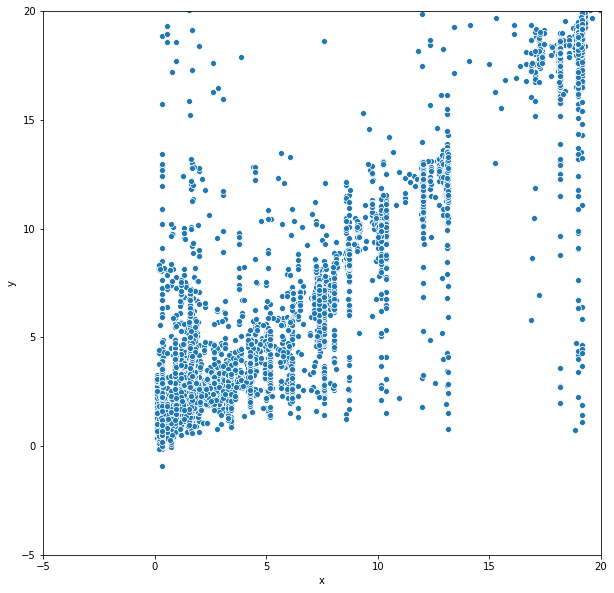

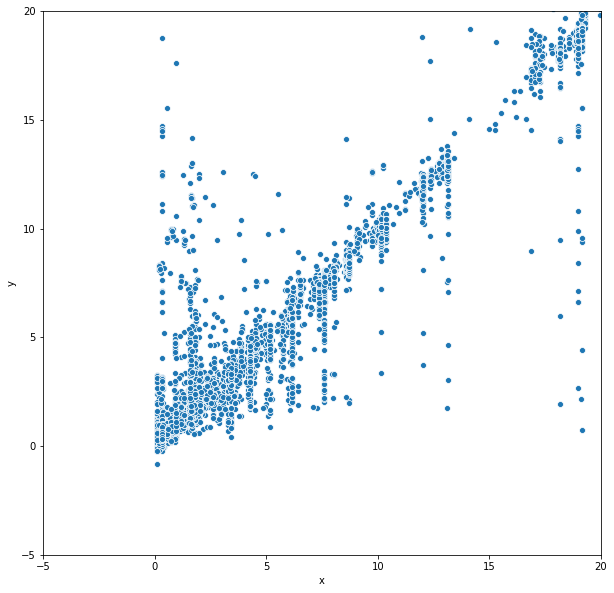

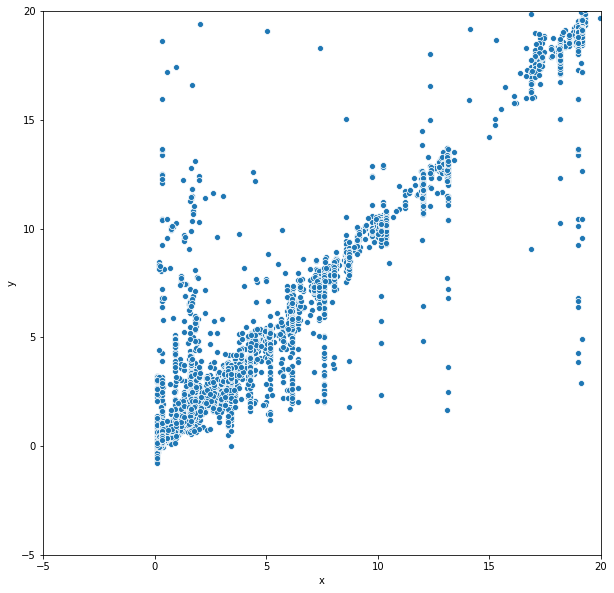

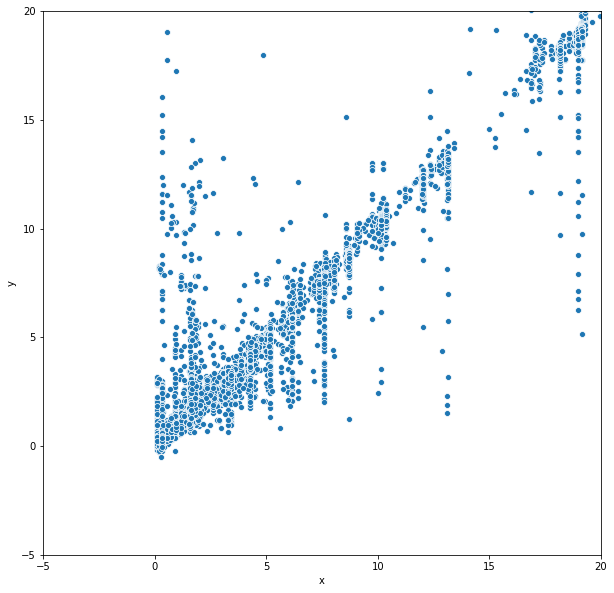

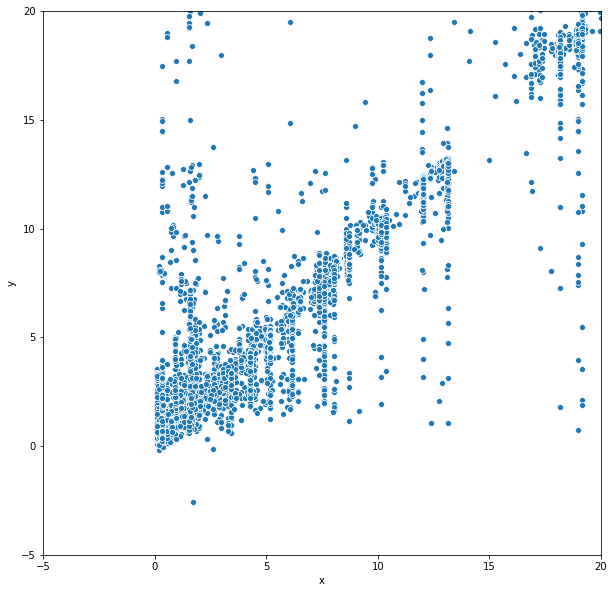

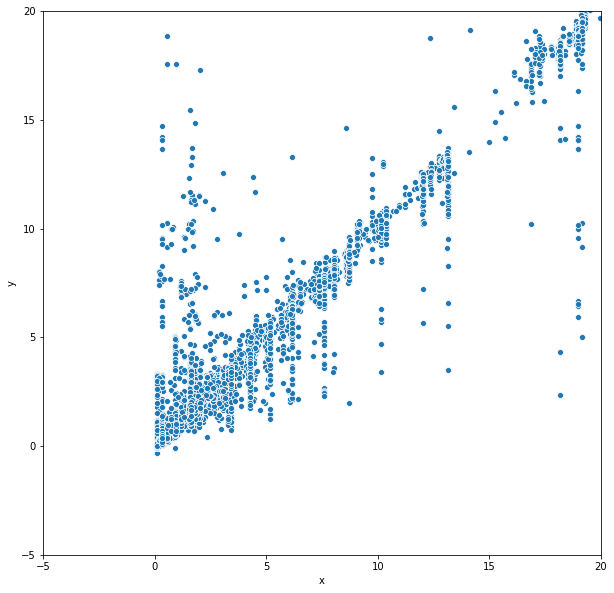

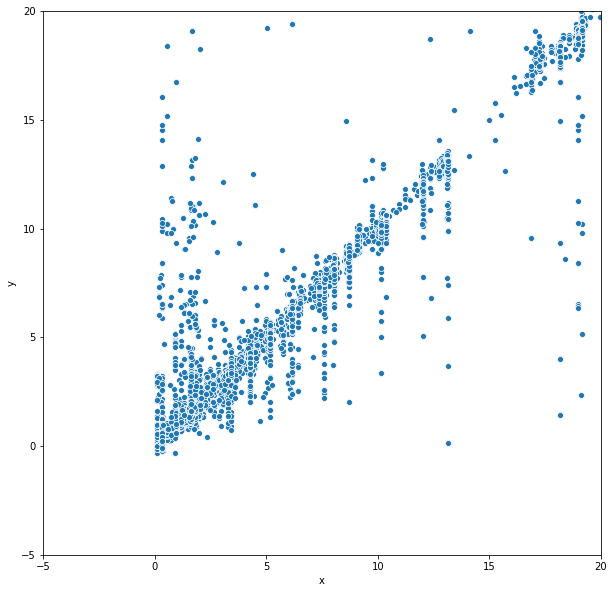

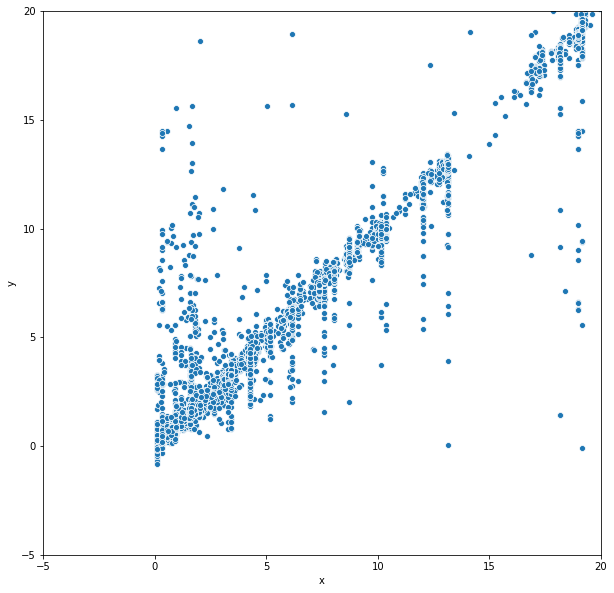

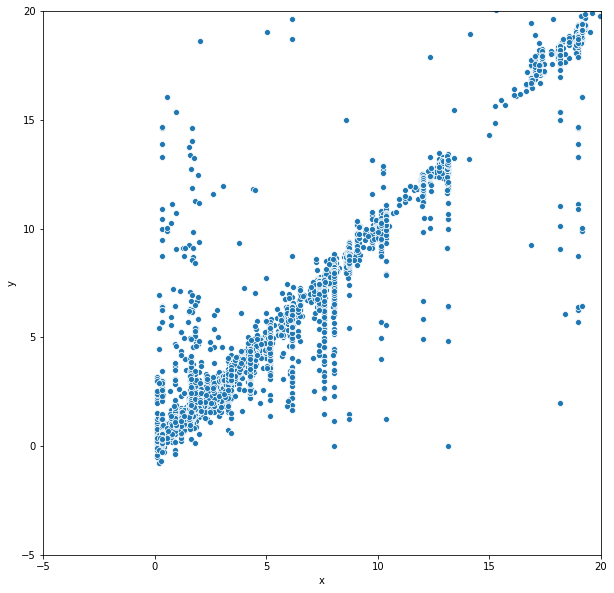

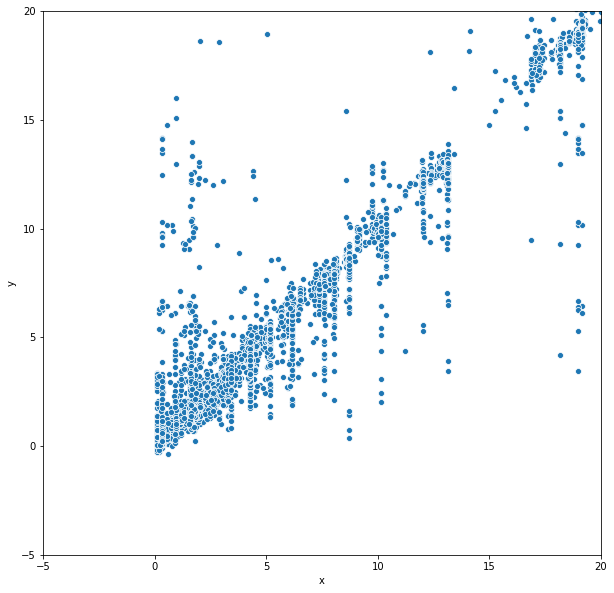

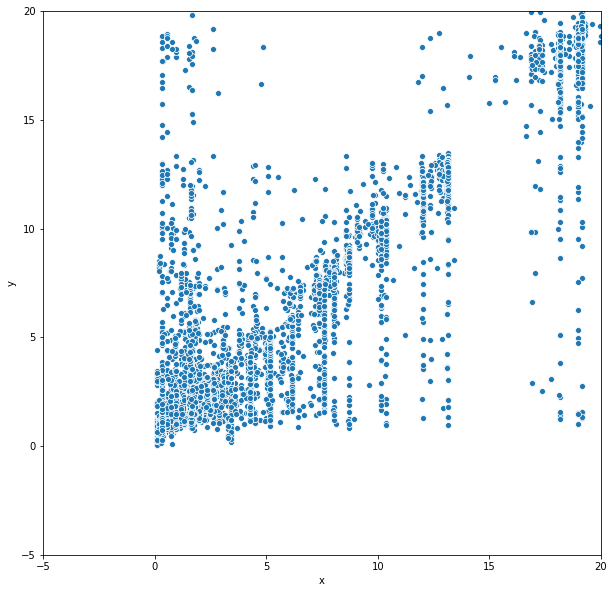

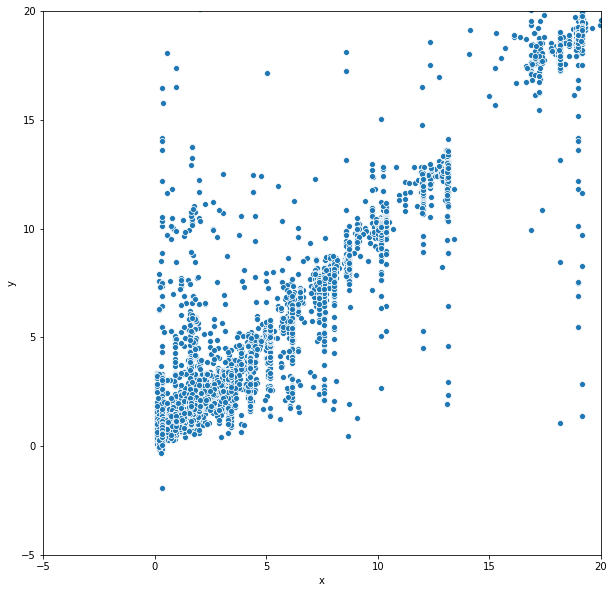

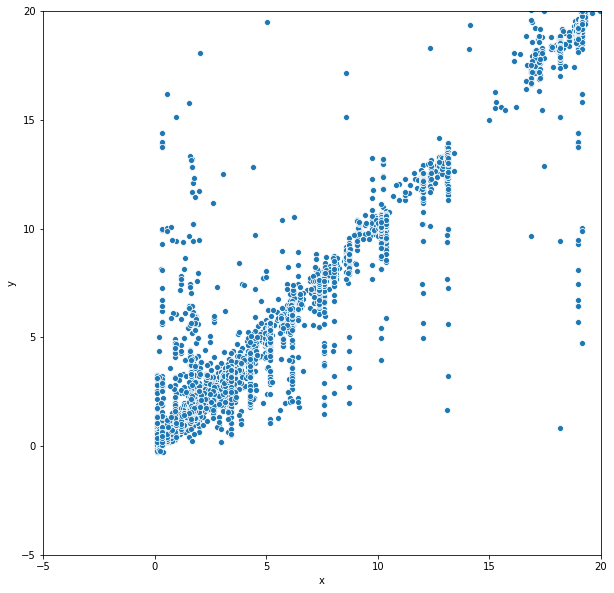

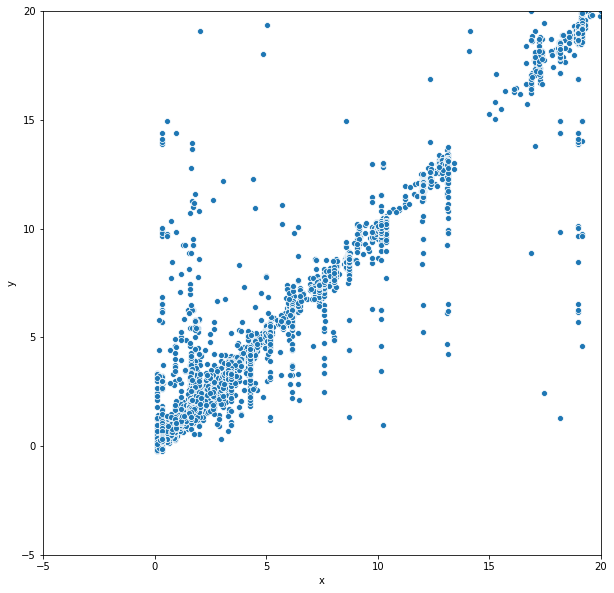

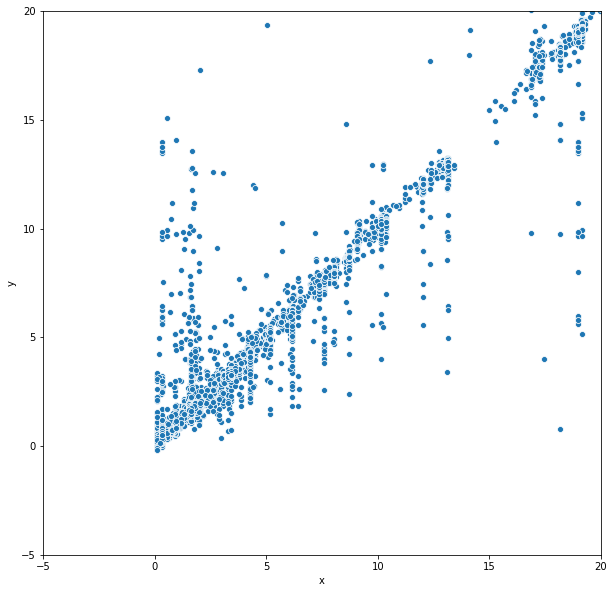

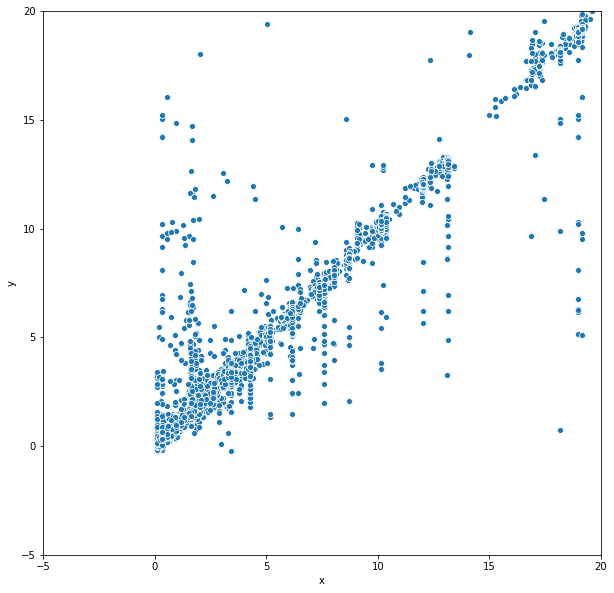

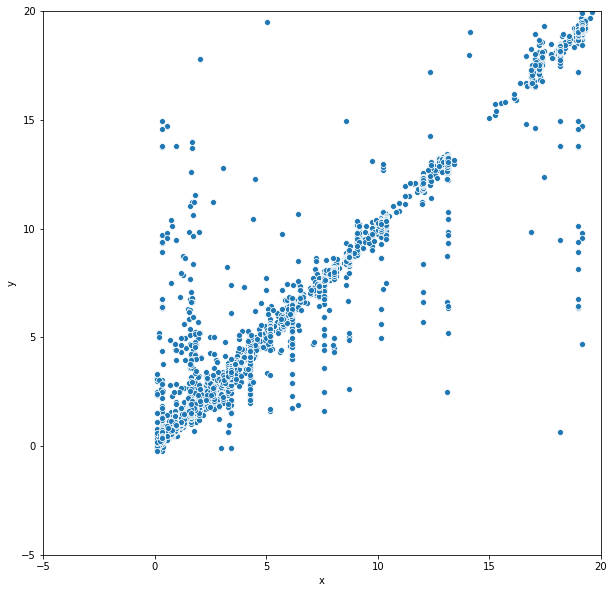

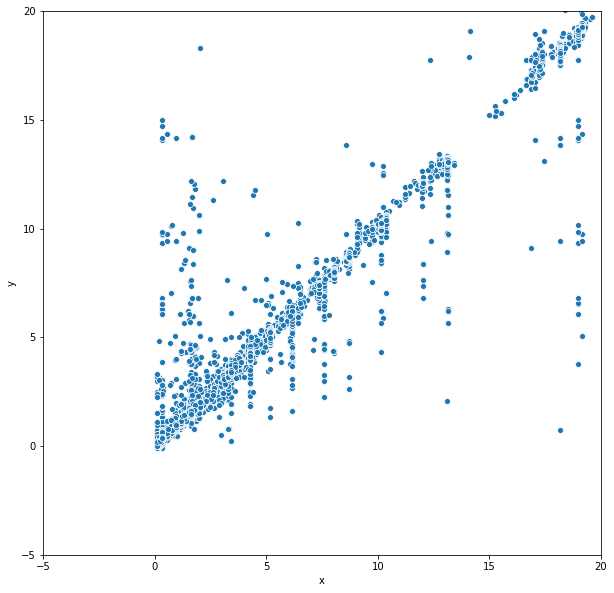

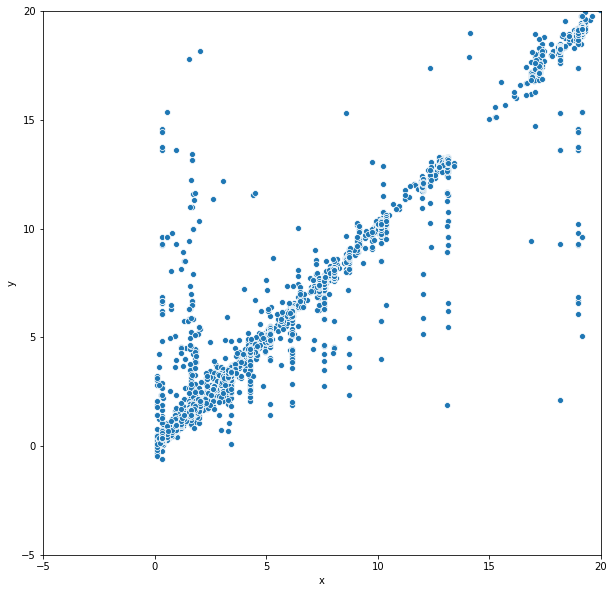

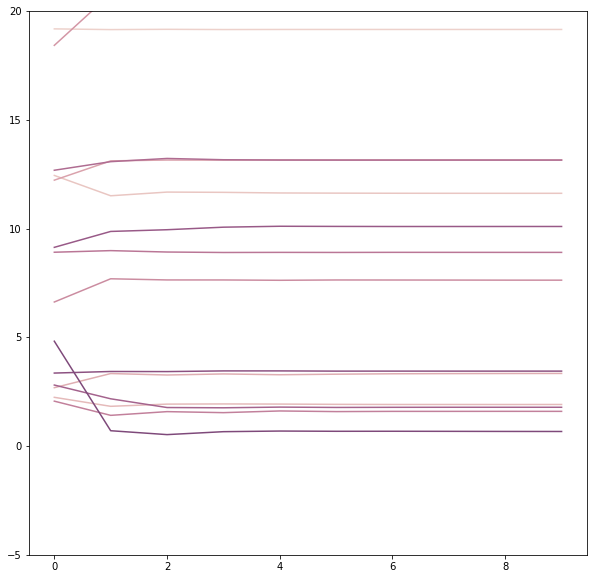

In [20]:
######################################################################################

import wandb
PROJECT="CircuitSeq"

notes = """
Exploring how graph deep learning models train on simulated regulatory network data.
"""

wandb.init(
    project="CircuitSeq", 
    tags=['explore', 'regulatory networks', 'simulated data', 'circuitseq'],
    entity='jvrana',
    save_code=False, 
    group="explore",
    notes=notes.strip()
)

######################################################################################

from pyrographnets.utils.tensorboard import new_writer
from pyrographnets.data import GraphBatch, GraphDataLoader
from tqdm.auto import tqdm
from pyrographnets.utils import _first

# make sure eval and test batches are different
assert not eval_batch.x.shape == test_batch.x.shape

device = 'cuda:0'

# # new tensorboard writer
# writer = new_writer('runs/circuit_seq')

# new model
net = Network()

with torch.no_grad():
    batch, _ = _first(loader)
    print(batch.shape)
    out = net(batch, 3)
# print(out.x)
net.to(device)

optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay=1e-2)
# optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.0009)
loss_fn = torch.nn.MSELoss()

def to(batch, device):
    return GraphBatch(
        batch.x.to(device),
        batch.e.to(device),
        batch.g.to(device),
        batch.edges.to(device),
        batch.node_idx.to(device),
        batch.edge_idx.to(device)
    )

import pandas as pd

def plot(target_data, out):
    x = target_data.x.cpu().detach().numpy().flatten()
    y = out.x.cpu().detach().numpy().flatten()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    df = pd.DataFrame({'x': x, 'y': y})
    ax = sns.scatterplot('x', 'y', data=df, ax=ax)
    ax.set_ylim(-5, 20)
    ax.set_xlim(-5, 20)
    return ax, fig

# training
net.train()
for epoch in tqdm(range(3000)):
    net.train()
    running_loss = 0.
    for batch_idx, (train_data, target_data) in enumerate(loader):
        train_data.contiguous()
        target_data.contiguous()
        target_data = target_data.clone()
#         target_data.x = torch.randn(*target_data.x.shape) * 0.1 + target_data.x
#             test_data = batch.mask(*test_mask)
#             target_data = batch.mask(*test_mask, invert=True)
        train_data = to(train_data, device)
        target_data = to(target_data, device)
        out = net(train_data, 5)
        assert out[-1].x.shape == target_data.x.shape
        
        optimizer.zero_grad()
        
        loss = torch.tensor(0.).to(device)
#         loss += loss_fn(out[-1].x, target_data.x)
        for _out in out:
            loss += loss_fn(_out.x, target_data.x)
#             loss += torch.nn.BCEWithLogitsLoss(_out.e, target_data.e)
#         loss = loss / len(out) / loader.batch_size
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
    wandb.log({'test_loss': running_loss, 'epoch': epoch}, step=epoch)

    if epoch % 10 == 0:
        eval_loss = 0.
        net.eval()
        with torch.no_grad():
            for eval_data, eval_target in eval_loader:
                eval_data = to(eval_data, device)
                eval_target = to(eval_target, device)
                eval_outs = net(eval_data, 10)
                eval_loss += loss_fn(eval_outs[-1].x, eval_target.x) / eval_loader.batch_size
#                 eval_loss += loss_fn(eval_outs[-1].e, eval_target.e) / eval_loader.batch_size
            wandb.log({'eval loss': eval_loss / eval_batch.x.shape[0] * 1000, 'epoch': epoch}, step=epoch)
    
    if epoch % 20 == 0:
        with torch.no_grad():
            for eval_data, eval_target in eval_loader:
                eval_data = eval_data.to(device)
                eval_target = to(eval_target, device)
            predicted = net(eval_data, 10)[-1]
            ax, fig = plot(eval_target, predicted)
#             wandb.log({'eval': eval_target, 'predicted': predicted}, step=epoch)
#             wandb.log({'compare': fig}, step=epoch)
#             writer.add_figure('compare', fig, epoch)
#             writer.add_histogram('select_weight', 
#                                   list(net.select_index.modules())[2][0].weight.data,
#                                 epoch)
            wandb.log({
                'edge_attr': wandb.Histogram(out[-1].e.cpu()),
                'node_attr': wandb.Histogram(out[-1].x.cpu())
            }, step=epoch)
#             writer.add_histogram('edge_attr', out[-1].e, epoch)
#             writer.add_histogram('node_attr', out[-1].x, epoch)
            
        with torch.no_grad():
            pass
#             ax, fig = plot_kinetics(net, eval_data, 10)
#             wandb.log({
#                 'kinetics': fig
#             }, step=epoch)
#             writer.add_figure('kinetics', fig, epoch)
#     if epoch % 10 == 0:
#         net.eval()
#         with torch.no_grad():
#             ax, fig = plot(target_data, net(train_data, 10)[-1])
#             writer.add_figure('compare', fig, epoch)

#     if epoch % 1 == 0:
# #         k = 'core.node_block.block_dict.mlp.resolved_module.blocks.0.blocks.0.weight'
# #         writer.add_histogram(k, net.state_dict()[k])
#         writer.add_histogram('out', out[-1].x)
        


{'features': tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])}
{'features': tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])}
{'features': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])}
{'features': tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])}
{'features': tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])}


(<matplotlib.axes._subplots.AxesSubplot at 0x7f4641f52c50>,
 <Figure size 720x720 with 1 Axes>)

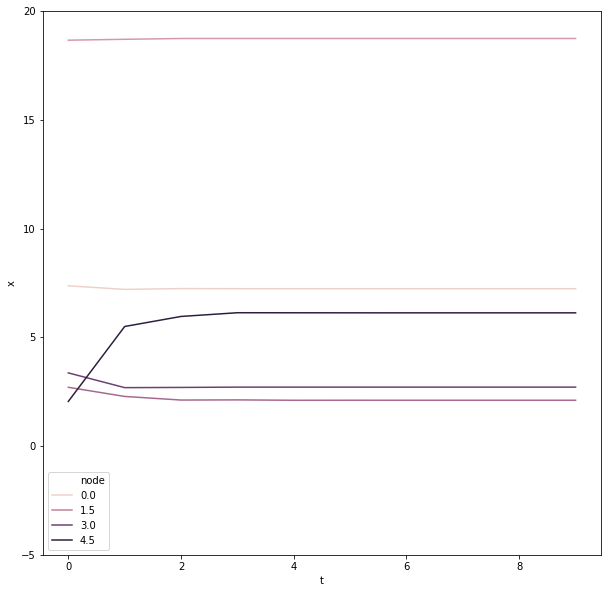

In [24]:
g = from_nodes([
    (0, 0, 2),
    (2, 2, 4),
    (4, 4, 6),
    (6, 6, 8),
    (2, 10, 10)
])
g = add_features(g, False)
for n, ndata in g.nodes(data=True):
    print(ndata)
batch = GraphBatch.from_networkx_list([g])
batch = to(batch, device)

plot_kinetics(net, batch, 10)
# net(batch, 10)